# General setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic
from astropy.coordinates import Angle, Latitude, Longitude
import astropy.stats as astats
from astropy import units as u
from mpl_toolkits.axes_grid1 import AxesGrid
import sys
from matplotlib.path import Path
from scipy import interpolate
from colorspacious import cspace_convert

In [4]:
field_list = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','33','62','130','131','133','134','135','136','137','138','139','140','141','142','143','144','145','147','148','149','150','176','177','178','179','180','181']
model_list = ['mesa']
coeff_list = ['decam']

In [25]:
# We want to have a file with the basic data of each field summarized. So far, this data includes:
#   - Field number
#   - Degrees from SMC centre
#   - Position Angle
#   - Area in deg^2
coord_list = read_txt('/home/pol/PhD_DATA/SMASH_DATA/smash_fields_final.txt', cols = (0,4,5))
field_coord_SMC = np.array(coordinate_calculator(coord_list))

inner_radius = np.where(field_coord_SMC[:,1]< 15)
inner_fields = field_coord_SMC[inner_radius,0]
field_list = [str(int(x)) for x in inner_fields[0]]

field_coord_SMC = np.array(coordinate_calculator(coord_list))
field_coord_SMC.shape = len(field_list), 3
print field_coord_SMC.shape

(39, 3)


In [51]:
areas = []
#alternative_field_list = ['4','9','14','177']
for field in field_list:
    if field == '4' or field == '9' or field == '1':
        name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits' % (field)
    else:
        name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field)
    data, header = read_fits(name_field_data)
    data = data['RA'], data['DEC']
    bin_number = int(175 + 0.15 * (len(data[0])/1000))
    areas.append(field_area_calculator(data, field, bin_number))
    print('Field %s Area (degrees^2):' % (field), areas[-1], 'using', bin_number, 'bins.')
#np.savetxt('/home/pol/PhD_DATA/SMASH_DATA/Field_area_info.txt', np.stack(field_list, areas))

/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


('Field 8 Area (degrees^2):', 2.672050090661163, 'using', 185, 'bins.')
('Field 17 Area (degrees^2):', 2.6740567684877465, 'using', 184, 'bins.')
('Field 23 Area (degrees^2):', 2.4629563570868154, 'using', 181, 'bins.')
('Field 24 Area (degrees^2):', 2.1410345203156824, 'using', 179, 'bins.')
('Field 25 Area (degrees^2):', 2.443896003704472, 'using', 181, 'bins.')
('Field 33 Area (degrees^2):', 2.4641610455570313, 'using', 182, 'bins.')
('Field 62 Area (degrees^2):', 2.695851533595759, 'using', 184, 'bins.')
('Field 130 Area (degrees^2):', 2.7583074115841515, 'using', 186, 'bins.')
('Field 131 Area (degrees^2):', 2.74877902167433, 'using', 188, 'bins.')
('Field 133 Area (degrees^2):', 2.7991902401182496, 'using', 191, 'bins.')
('Field 134 Area (degrees^2):', 2.5768950736941147, 'using', 183, 'bins.')
('Field 135 Area (degrees^2):', 2.63509478976318, 'using', 184, 'bins.')
('Field 136 Area (degrees^2):', 2.3824901262332703, 'using', 181, 'bins.')
('Field 137 Area (degrees^2):', 2.579388

In [6]:
#field_list_float = [float(x) for x in field_list]
#np.savetxt('/home/pol/PhD_DATA/SMASH_DATA/Field_area_info.txt', np.stack((field_list_float, areas)).T, fmt = '%.0f %.2f')
areas_file = np.loadtxt('/home/pol/PhD_DATA/SMASH_DATA/Field_area_info.txt')
areas = areas_file.T[1]
print areas_file

[[  1.     2.49]
 [  2.     2.68]
 [  3.     2.76]
 [  4.     1.07]
 [  5.     2.75]
 [  6.     2.7 ]
 [  7.     2.76]
 [  8.     2.67]
 [  9.     1.22]
 [ 10.     2.63]
 [ 11.     2.76]
 [ 12.     2.81]
 [ 13.     2.77]
 [ 14.     2.78]
 [ 15.     2.78]
 [ 16.     2.8 ]
 [ 17.     2.67]
 [ 18.     2.69]
 [ 19.     2.46]
 [ 20.     2.42]
 [ 21.     2.48]
 [ 22.     2.63]
 [ 23.     2.46]
 [ 24.     2.14]
 [ 25.     2.44]
 [139.     2.64]
 [141.     2.51]
 [142.     2.69]
 [143.     2.48]
 [144.     2.73]
 [145.     2.66]
 [147.     2.4 ]
 [148.     2.24]
 [149.     2.73]
 [150.     2.52]
 [176.     2.82]
 [177.     2.81]
 [178.     2.87]
 [181.     2.4 ]]


In [7]:
xbinsize = 0.1
ybinsize = 0.3
xbins = np.arange( start = -1, stop = 2, step = xbinsize)
ybins = np.arange( start = 14, stop = 24, step = ybinsize)

# Respectively u,g,r,i,z. Ex: u0 = u - 4.239*E(B-V)
extinction_coeff_sdss = np.array([4.239, 3.303, 2.285, 1.698, 1.263])
# Respectively u,g,r,i,z,Y. Ex: A_u = R_u*EBV_SFD98 ; u0 = u - A_u
extinction_coeff_decam = np.array([3.9631, 3.1863, 2.1401, 1.5690, 1.1957, 1.0476])

vertex_coord = [(-1,14),(-1,20),(0,24),(0.9,24),(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
#young_vertex_coord = [(-1,14),(-1,20),(-0.25,22),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
#old_vertex_coord = [(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(0.75,23)]
halo_vertex_coord = [(0.2, 18), (0.4, 18), (0.4, 19), (0.2, 19)]

# Modules

In [8]:
def read_fits (name):
    hdulist = fits.open(name)
    field_data = hdulist[1].data
    header = hdulist[1].header
    hdulist.close()
    return field_data, header

In [9]:
def read_txt (name, cols = None):
    field_data = np.loadtxt(name, comments='#', usecols = cols)
    return field_data.T

In [10]:
# Function that dereddenes a set of magnitudes. It uses the standard method and the user has to decide which coefficients wants to use.
# By default, it uses the filters of DECam
def dereddener(mag, filter, EBV, filterset = 'decam'):
    #EBV[np.where(EBV > 0.3)] = 0.037 #This line is to ensure we don't have unrealistic extinction values in the SMC centre. The limit is debatable.
    if filterset == 'decam':
        return mag - extinction_coeff_decam[filter]*EBV
    else:
        return mag - extinction_coeff_sdss[filter]*EBV

In [11]:
# Function that applies a completeness correction to the MW models in SMASH.
# Input: the number of the field we're dealing with (field_number) and the data in the file of the model.
# Output: A 2D histogram representing the corrected CMD of the model within the stablished colour and mag limits.
# Global variables: xbins and ybins.
def completeness_corrector(field_number, model, area):
    name_field_complete = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_complete_stars.fits.gz' % (field_number)
    complete, header = read_fits(name_field_complete)
    
    # Applying the completeness to the data.
    # Step 1. Retrieving the completeness data available.
    magG_complete = complete['INP_G']
    magI_complete = complete['INP_I']
    recovered = complete['RECOVERED']
    
    # Step 2. Construct two sets of data. One for the recovered stars and one for the whole dataset.
    not_recovered_indeces = np.where(recovered == 0)
    magG_recovered, magI_recovered = np.delete(magG_complete, not_recovered_indeces), np.delete(magI_complete, not_recovered_indeces)
    recovered_data = np.vstack([magG_recovered - magI_recovered, magG_recovered])
    complete_data = np.vstack([magG_complete - magI_complete, magG_complete])
    
    # Step 3. Construct histograms for the 2 sets.
    hist2d_complete = np.histogram2d(complete_data[0], complete_data[1], bins = [xbins,ybins])
    hist2d_recovered = np.histogram2d(recovered_data[0], recovered_data[1], bins = [xbins,ybins])
    #hist2d_complete, hist2d_recovered = np.array(hist2d_complete), np.array(hist2d_recovered)
    
    # Step 4. To make sure we have data everywhere we're studying we set the unfilled bins with a 100% completion.
    hist2d_complete[0] [hist2d_complete[0] == 0.] = 1.0
    hist2d_recovered[0] [hist2d_complete[0] == 0.] = 1.0
    
    # Step 5. We compute the recovered ratio and apply it to the model.
    recovered_ratio = np.divide(hist2d_recovered[0], hist2d_complete[0])
    corrected_model = model * recovered_ratio
    
    #Step 6. We have to take into account that the model uses an area of 3 deg^2, so we also have to correct for that.
    corrected_model = corrected_model * (area/3.0)
    
    return corrected_model

In [12]:
# Function that gets out a scaling factor for the model that depends exclusively on the galactic latitude.
# This is made to reduce the errors in the subtraction of the model.
def galactic_latitude_model_scaler(field_number, population):
    # First we need to get the galactic coordinates for our field.
    coord_list = read_txt('/home/pol/PhD_DATA/SMASH_DATA/smash_fields_final.txt', cols = (0,4,5))
    for field in coord_list.T:
        #print field[0], field_number
        if field[0] == float(field_number):
            print 'hola'
            field_coord =  SkyCoord(ra = field[1]*u.degree, dec = field[2]*u.degree)
            b_field = field_coord.galactic.b.deg
            break
    # Good, now let's find the galactic latitude for the centre of the SMC.
    SMC_center = SkyCoord('0h52m44s', '-72d49m42s')
    b_smc = SMC_center.galactic.b.deg
    # Well that was easy. Now the final bit. Return the value of scaling corresponding to the right population.
    # The numbers are taken based on an analysis from its dependance to the b coordinate without any scaling.
    if population == 'young':
        return np.exp(0.0291*(b_field - b_smc))
    if population == 'old':
        return np.exp(0.05695*(b_field - b_smc))
    if population == 'all':
        return np.exp(0.02436*(b_field - b_smc))

In [13]:
# Computes a 2D histogram of observed CMD and MW model CMD and subtracts the later to the fisrt one. Then, plots the result.
def cmd_subtractor (data, model, field_number, model_name, filterset, area, population, halo_scaling = True):
    magG = data['G']
    magI = data['I']
    star_prob = data['PROB']
    EBV = data['EBV']
    coordinates = data['RA'], data['DEC']

    magG_0, magI_0 = dereddener(magG, 1, EBV, filterset), dereddener(magI, 3, EBV, filterset)
    GminusI = magG_0 - magI_0
    cmd_data = np.vstack([GminusI, magG_0])
    #cmd_data = np.array(cmd_data)
# Remove blue stars, possibly white dwarfs. These stars are too blue to be stars from a MC.
    bad_indeces = np.where(cmd_data[0] < -1)
    cmd_data = np.delete(cmd_data, bad_indeces, 1)
# Remove faint stars beyond the threshold of the model. We don't have information of how the MW affects our data at this point. In this way we are able to reduce the errors in the data sample.
    bad_indeces = np.where(cmd_data[1] > 24)
    cmd_data = np.delete(cmd_data, bad_indeces, 1)
# Remove red stars where MW models are known to fail and where there is no expectation of MC stars.
    bad_indeces = np.where(cmd_data[0] > 2)
    cmd_data = np.delete(cmd_data, bad_indeces, 1)
# Remove bright stars.
    bad_indeces = np.where(cmd_data[1] < 14)
    cmd_data = np.delete(cmd_data, bad_indeces, 1)
# Remove objects with low stellaricity probability
    #bad_indeces = np.where(star_prob <= 0.6)
    #cmd_data = np.delete(cmd_data, bad_indeces, 1)


# We want first to scale the model to the data. We only want to scale the halo stars in the model since this is the most crucial component that is affecting our results. 
    halo_scaling_factor = halo_scaler(model, magG_0, magI_0, field_number, area)
    #print(halo_scaling_factor)
    
# We are going to separate the sample in halo and not halo. To apply the scaling to the halo alone.
    model_halo = np.delete(model, np.where(model[8] == 9.) , 1)
    model_rest = np.delete(model, np.where(model[8] < 9.) , 1)

    
    hist2d_data = np.histogram2d(cmd_data[0], cmd_data[1], bins = [xbins,ybins])
    hist2d_model_halo = np.histogram2d((model_halo[1] - model_halo[3]), model_halo[1], bins = [xbins,ybins])
    hist2d_model_rest = np.histogram2d((model_rest[1] - model_rest[3]), model_rest[1], bins = [xbins,ybins])

# In order for our uncertainties to be realistic we need to do a model scaling according to the galactic latitude.
# Here we are going to find the value for this scaling that applies to the specific field and population chosen.
    b_scaling = galactic_latitude_model_scaler(field_number, population)
    
    # Applying the completeness to the data.
    # Step 1. Retrieving all the simulated stars. We use input magnitudes because they are available for all the stars, even the not recovered.
    
    #magG_complete = complete['INP_G']
    #magI_complete = complete['INP_I']
    #recovered = complete['RECOVERED']
    #not_recovered_indeces = np.where(recovered == 0)
    #magG_recovered, magI_recovered = np.delete(magG_complete, not_recovered_indeces), np.delete(magI_complete, not_recovered_indeces)
    #recovered_data = np.vstack([magG_recovered - magI_recovered, magG_recovered])
    #complete_data = np.vstack([magG_complete - magI_complete, magG_complete])    
    #hist2d_complete = np.histogram2d(complete_data[0], complete_data[1], bins = [xbins,ybins])
    #hist2d_recovered = np.histogram2d(recovered_data[0], recovered_data[1], bins = [xbins,ybins])
    #hist2d_complete, hist2d_recovered = np.array(hist2d_complete), np.array(hist2d_recovered)
    #hist2d_complete[0] [hist2d_complete[0] == 0.] = 1.0
    #hist2d_recovered[0] [hist2d_complete[0] == 0.] = 1.0
    #recovered_ratio = np.divide(hist2d_recovered[0], hist2d_complete[0])
    
#    print min(complete_data[0]),max(complete_data[0]),max(complete_data[1]),min(complete_data[1])
#    print min(cmd_data[0]), max(cmd_data[0]), max(cmd_data[1]), min(cmd_data[1])
#    recovered_ratio = np.reshape(recovered_ratio, -1)
#    plt.imshow(recovered_ratio.T, extent = (min(complete_data[0]),max(complete_data[0]),max(complete_data[1]),min(complete_data[1])), aspect = 'auto', origin = 'upper')
#    plt.colorbar()
#    plt.show()


# IMPORTANT LINE BELOW!!! With this line we correct the data with the model.
# The correction is separated between halo correction and "the rest" correction, so I can scale both things separately.
# Or don't scale them at all.
    
    if halo_scaling == True:
        hist2d = hist2d_data[0] - halo_scaling_factor * completeness_corrector(field_number, hist2d_model_halo[0], area) - completeness_corrector(field_number, hist2d_model_rest[0], area)
    else:
        hist2d = hist2d_data[0] - b_scaling*(completeness_corrector(field_number, hist2d_model_halo[0], area) + completeness_corrector(field_number, hist2d_model_rest[0], area))
#    OneToTwoDimHist(hist2d)

# Apply a strong cut, where we do not take into account stars that are below the noise level created by subtracting the model from the data, i.e. the values that are below a threshold set by the lowest negative value in the sample.
#    print np.amin(hist2d)
#    hist2d [hist2d < abs(np.amin(hist2d))] = np.nan
# Useful command for plotting.
    hist2d [hist2d == 0.] = np.nan

# Set the overall figure for the CMD plotting
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':16})
    fig = plt.figure()
    ax = fig.add_subplot(111)

#    print np.nanmax(hist2d)/(np.nanmax(hist2d) + abs(np.nanmin(hist2d)))
    hist_final = ax.imshow(hist2d.T, extent = (min(cmd_data[0]),max(cmd_data[0]),min(cmd_data[1]),max(cmd_data[1])), aspect = 'auto', origin = 'lower', cmap = 'viridis_r', norm = colors.SymLogNorm(1), interpolation = 'none') #, norm = colors.SymLogNorm(0.1)

    plt.gca().invert_yaxis()
    plt.ylabel('g')
    plt.xlabel('g-i')
    cbd = plt.colorbar(hist_final)
    plt.title('Field %s' % (field_number))
    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/CMD_%s_%s.png' % (field_number, model_name))
#    plt.show()
    plt.close()
    return hist2d, hist2d_data

In [31]:
# Surface brightness calculator. It uses a corrected 2D histogram array where counts mean stars. The magnitudes are taken from the 3rd array inside the original data. Both arrays should have compatible sizes.
def surface_brightness_calculator(corrected_data, original_data, field_number, model, coordinates, data_set, field_area, population):
    #bin_number = int(175 + 0.15 * (len(data[0])/1000))
    #field_area_arcsec = 60 * 60 * 60 * 60 * field_area_calculator(coordinates, field_number, bin_number)
    field_area_arcsec = 60 * 60 * 60 * 60 * field_area
    
    #mags = original_data[2][:-1] + ybinsize/2
    #clrs = original_data[1][:-1] + xbinsize/2
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T

    if population == 'young': 
        vertex_coord = [(-1,14),(-1,20),(-0.2,23),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
    else:
        vertex_coord = [(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(0.75,23)]
    path = Path(vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))

    #cut_corrected_model = np.ma.masked_array(corrected_data, mask=grid.T)
    
    grid = ~np.array(grid)
    cut_corrected_data = np.ma.masked_array(corrected_data, mask=grid.T)



    # Set the overall figure for the CMD plotting
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':16})
    fig = plt.figure(figsize= (8,5))
    ax = fig.add_subplot(111)

    hist_final = ax.imshow(corrected_data.T, aspect = 'auto', origin = 'upper', extent = (min(original_data[1]), max(original_data[1]), max(original_data[2]), min(original_data[2])), cmap = 'viridis_r', norm = colors.SymLogNorm(0.1), interpolation = 'none')
    vertex_list = [list(x) for x in vertex_coord]
    vertex_array = np.array(vertex_list)
    polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, color = 'orange')
    ax.add_patch(polygon)
    #vertex_list = [list(x) for x in halo_vertex_coord]
    #vertex_array = np.array(vertex_list)
    #polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.4, color = 'red')
    #ax.add_patch(polygon)
    plt.ylabel('g')
    plt.xlabel('g-i')
    cbd = plt.colorbar(hist_final)
    plt.title('Field %s' % (field_number))

    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/CMD_modelzone_field%s_%s_%s_%s.png' % (field_number, model, data_set, population))
    plt.close()


    
    #Code for computing the SMC+MW SB.
    cut_corrected_data [cut_corrected_data < 0] = 0. #This line sets the bins to 0 if they are negative, to avoid having negative fluxes.
    stars_per_mag = np.nansum(cut_corrected_data, 0)
    #print(stars_per_mag)
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    total_flux = np.sum(flux_per_mag_and_star * stars_per_mag)
    flux_arcsec = total_flux / field_area_arcsec
#    print flux_arcsec
    mag_arcsec = -2.5*np.log10(flux_arcsec)
    
    
    #Code for computing the MW SB.
    #model_stars_per_mag = np.nansum(cut_corrected_model, 0)
    #model_flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    #model_total_flux = np.sum(model_flux_per_mag_and_star * model_stars_per_mag)
    
    return mag_arcsec, total_flux

In [15]:
# Function to retrieve the surface brightness of the model for each field.
def model_SB(model):
        
    model_g = model[1]
    model_gi = model[1] - model[3]
    
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T
    
    path = Path(vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))
    
    model_2dhist, xedges, yedges = np.histogram2d(model_gi, model_g, bins = [xbins,ybins])
    
    cut_model_out = np.ma.masked_array(model_2dhist, mask=grid.T)
    grid = ~np.array(grid)
    cut_model_in = np.ma.masked_array(model_2dhist, mask=grid.T)
    
    stars_per_mag = np.nansum(cut_model_in, 0)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    flux_in = np.sum(flux_per_mag_and_star * stars_per_mag)
    
    stars_per_mag = np.nansum(cut_model_out, 0)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    flux_out = np.sum(flux_per_mag_and_star * stars_per_mag)
    
    return flux_in, flux_out

In [16]:
# Function that constructs the SB profile based on the retrieved magnitudes and the radial distance from the center of the SMC.
def SB_profile(fields_data, fields_errors, fields_coord, model, filterset):

    distance_SMC = 62 #kpc
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':16})
    fig = plt.figure(figsize= (8,5))
    ax = fig.add_subplot(111)

    fields_coord = fields_coord.T
    plot = ax.scatter(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC, fields_data, c = fields_coord[2], cmap=cm.coolwarm, vmin = 0, vmax = 360, s = 35, zorder=10)
    plt.errorbar(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC, fields_data, yerr = fields_errors, fmt='none', zorder=1)
    #for i, field_number in enumerate(fields_coord[0]):
    #    plt.annotate(field_number, (str(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC), str(fields_data)))
    cb = plt.colorbar(plot)
    cb.set_label('Position Angle')
    plt.xlim(xmin=0)
    plt.ylim(ymin=23, ymax=32)
    plt.xlabel('r (kpc)')
    plt.ylabel('g (mag/arcsec$^2$)')
    plt.gca().invert_yaxis()
    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/SB_profile_15deg_errors_%s_%s.png' % (model, filterset))
    plt.close()

In [17]:
# It returns, for a given set of SMASH fields, the values of its position angle (PA) and distance (rho), in degrees, to the SMC center.
# field_list is a 1D array with the numbers of the fields in STRINGS
# coordinates_data is a 2D array with 3 columns one for the name of the field and the other two for its RA and DEC, in this order and in degrees.
def coordinate_calculator (coordinates_data):
    SMC_center = SkyCoord('0h52m44s', '-72d49m42s')
    LMC_center = SkyCoord('05h27m36s', '-69d52m0s')
    field_list_2 = np.array([int(x) for x in field_list])
    coordinates_data = coordinates_data.T
    coordinates = []
    for field in coordinates_data:
        for selected in field_list_2:
            if field[0] == selected:
                field_data = []
                field_data.append(selected)
                field_coord =  SkyCoord(ra = field[1]*u.degree, dec = field[2]*u.degree)
                # We use the rules described in Van der Marel & Cioni 2001 to compute the distance to the center of the SMC. We need to know both sinPA and cosPA to be able to determine in which quadrant is the angle.
                rho = np.arccos(np.cos(field_coord.dec.radian) * np.cos(SMC_center.dec.radian) * np.cos(field_coord.ra.radian - SMC_center.ra.radian) + np.sin(field_coord.dec.radian) * np.sin(SMC_center.dec.radian))
                field_data.append(np.rad2deg(rho))
                cosPA = -np.cos(field_coord.dec.radian) * np.sin(field_coord.ra.radian - SMC_center.ra.radian) / np.sin(rho)
                sinPA = (np.sin(field_coord.dec.radian) * np.cos(SMC_center.dec.radian) - np.cos(field_coord.dec.radian) * np.sin(SMC_center.dec.radian) * np.cos(field_coord.ra.radian - SMC_center.ra.radian)) / np.sin(rho)
                # We use the extraordinary resources of complex numbers and python functions to obtain the PA in a very cool way.
                PA = np.angle(complex(cosPA,sinPA), deg = True)
                # This line below is there to obtain the angles in the right convention, i.e. the astrophysical one.
                PA = PA - 90
                PA = np.where(PA < 0, PA + 360, PA)
                field_data.append(PA)
                coordinates.append(field_data)
    return coordinates

In [18]:
# Function to scale the number of halo stars in the model to match it to the data.
# Input: full model data with all columns (model_data), magnitudes G and I for the SMASH data (magG_0, magI_0) and field_number.
def halo_scaler (model_data, magG_0, magI_0, field_number, field_area):
    # Prepare the smash_data
    GminusI_0 = magG_0 - magI_0
    
    # Prepare the model_data
    #model_data = np.array(model_data)
    model_data = np.delete(model_data, np.where(model_data[8] < 9.) , 1) # We only want halo stars (9.0).
    modelG = model_data[1]
    modelGI = model_data[1] - model_data[3]
    
    # Step 0. Set up the overall CMD region.
    #xbins = np.arange( start = -1, stop = 2, step = xbinsize)
    #ybins = np.arange( start = 14, stop = 24, step = ybinsize)
    
    # Step 1. Create an histogram of the model and the data
    hist2d_model = np.histogram2d(modelGI, modelG, bins = [xbins,ybins])
    hist2d_data = np.histogram2d(GminusI_0, magG_0, bins = [xbins,ybins])

    # Step 2. Set up the region of interest.
    mags = hist2d_model[2][:-1] + ybinsize/2
    clrs = hist2d_model[1][:-1] + xbinsize/2
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T
    
    #vertex_coord = [(0.2, 18), (0.4, 18), (0.4, 19), (0.2, 19)] # This is what defines the vertices of the region to be defined.
    
    path = Path(halo_vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))
    grid = ~np.array(grid)

    # Step 3. Create a new cut histogram
    hist_model = completeness_corrector(field_number, hist2d_model[0], field_area)
    cut_hist2d_model = np.ma.masked_array(hist_model, mask=grid.T)
    cut_hist2d_data = np.ma.masked_array(hist2d_data[0], mask=grid.T)

    # Optional step. Check the results
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    #plt.rcParams.update({'font.size':16})
    #fig = plt.figure()
    #ax = fig.add_subplot(111)

    #check_hist = ax.imshow(cut_hist2d_model.T, aspect = 'auto', origin = 'upper', extent = (min(hist2d_model[1]), max(hist2d_model[1]), max(hist2d_model[2]), min(hist2d_model[2])))
    #plt.ylabel('g')
    #plt.xlabel('g-i')
    #cbd = plt.colorbar(check_hist)
    #plt.show()
    #plt.close()

    # Step 4. Counting the number of stars in the region of interest.
    stars_model = np.sum(cut_hist2d_model)
    stars_data = np.sum(cut_hist2d_data)
    
    #Step 5. Final result.
    return stars_data/stars_model
    #return 1.0

In [19]:
# Function that calculates the area in a sky region occupied by a given number of stars. The function bins the sky and counts the number of bins with data in it. The size of the bins can be changed accordingly by changing their number. The input must be a numpy array with the first 2 columns being RA and DEC in degrees.
def field_area_calculator (data, field, bin_number):
    # First of all, we must double check that the field is not in the meridian of RA=0, because this would cause problems with how the code computes the area. If it is in that meridian, we set the values in the 3rd and 4th quadrant to the 0 to -180 interval. In this way we have the values in this meridian continuous. Of course we expect to have no values in the 180 meridian cause this would cause the same problem again.
    # We will also multiply RA by cos(DEC) to avoid problems near the poles.
    if (max(data[0])-min(data[0])) > 180:
        new_ra = np.where(data[0] > 180, data[0] - 360, data[0])
        #new_ra = new_ra * np.cos(np.deg2rad(data[1]))
        #hist_coord = np.histogram2d(new_ra, data[1], bins = bins)
    else:
        #hist_coord = np.histogram2d(data[0], data[1], bins = bins)
        new_ra = data[0]
    
    # Secondly, we want to change the RA to RA*cos(DEC) to have a smaller range in this variable. And because we have to do it anyways.
    #mid_dec = (data[1][1:] + data[1][:-1]) * 0.5
    #new_ra_cosdec = new_ra * np.cos(np.deg2rad(data[1]))
    
    #binsRA = np.arange(min(new_ra), max(new_ra), binsize)
    #binsDEC = np.arange(min(data[1]), max(data[1]), binsize)
    # Then, we make an histogram of the data with the amount of bins provided.
    hist_coord = np.histogram2d(new_ra, data[1], bins = bin_number)
    
    # Then, we put nans on the zeros so that they appear white in the figure.
    hist_coord[0] [hist_coord[0] == 0.] = np.nan
    # We save a figure just to check if the histogram has enough/too much resolution.
    plt.figure(1, figsize=(16,9))
    plt.imshow(hist_coord[0])
    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/Field%sSkyView.png' % (field))
#    plt.show()
    plt.close()


    # We first compute the area of each bin, correcting the dra variable for cos(delta), which takes into account the fact that a RA circle at DEC=0 is greater that one at DEC=80.
    dra = np.diff(hist_coord[1])
    ddec = np.diff(hist_coord[2])
    mid_dec = (hist_coord[2][1:] + hist_coord[2][:-1]) * 0.5
    dra_cosdelta = dra * np.cos(np.deg2rad(mid_dec))
    # This line below creates a 2D grid of areas, to ensure that later on every bin is multiplied for the correct amount.
    area_bin = dra_cosdelta[:, None] * ddec
    hist_coord[0] [hist_coord[0] > 0.] = 1.0
    # We sum all the bins and mulpiply for the area of each bin.
    area = np.nansum(hist_coord[0] * area_bin)
    #print 'Field %s Area (degrees^2): ' % (field), area
    return area

# Main execution

In [1]:
population = 'young'

In [46]:
for filterset in coeff_list:
    for model_name in model_list:
        field_SB = []
        field_error = []
        model_field_flux = []
        data_field_flux = []
        print model_name, filterset
        print ''
        for field_number, field_area in zip(field_list, areas):
            if field_number == '4' or field_number == '9' or field_number == '1':
                name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits' % (field_number)
            else:
                name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field_number)
            name_field_model = '/home/pol/PhD_DATA/MODELS/CMD_field%s_%s.txt' % (field_number, model_name)
            field = 'Field %s' % (field_number)
            data, header = read_fits(name_field_data)
            model = read_txt(name_field_model)
            coordinates = data['RA'], data['DEC']
            corrected_data_hist, original_data = cmd_subtractor(data, model, field_number, model_name, filterset, field_area)
            
            
            data_set = 'data'
            temp1, temp2 = surface_brightness_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, data_set, field_area, population)
            field_SB, data_field_flux = np.append(field_SB, temp1), np.append(data_field_flux, temp2)
            #print field_SB[-1], model_field_flux[-1], data_field_flux[-1]
            
            #Here we retrieve the SB of the model in the 2 different regions of the CMD, in and out of the area of study.
            #model_flux_in, model_flux_out = model_SB(model)
            #print model_flux_in, model_flux_out
            
            #Now we calculate the part of the uncertainty due to the model.
            #model_error = ((model_flux_in/data_field_flux[-1]) * (model_field_flux[-1]/model_flux_out))**2
            
            #Next the area error.
            #area_error = 0.1 * 0.1
            
            #Finally the total error in the field.
            #field_error.append( (2.5/np.log(10)) * np.sqrt(model_error + area_error) )
            print 'The SB for field %s is:' % (field_number), field_SB[-1]
            
            #field_SB.append(surface_brightness_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, num_stars))
            #print field_number, model_name
            print ''
        #SB_profile(field_SB, field_error, field_coord_SMC, model_name, filterset)
        SB_data = np.stack((field_coord_SMC[:,0], field_coord_SMC[:,1], field_coord_SMC[:,2], field_SB)).T
        np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/SB_data_errors_%s_%s_15deg_27S_OLD.dat' % (model_name, filterset), SB_data, header='Field_number Distance_SMC(deg) PA(deg) SB(mag/arcsec^2)', fmt= '%.0f %.3f %.3f %.5f')
        


mesa decam



/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less


The SB for field 1 is: 29.541706778262423

The SB for field 2 is: 29.31706066492143

The SB for field 3 is: 26.3888401583732

The SB for field 4 is: 26.274178474999978

The SB for field 5 is: 26.174358895545417

The SB for field 6 is: 25.088371602566934

The SB for field 7 is: 25.92998128352184

The SB for field 8 is: 29.655139231162035

The SB for field 9 is: 27.207154961549453

The SB for field 10 is: 25.83596335776813

The SB for field 11 is: 25.49777837140749

The SB for field 12 is: 27.41516483347802

The SB for field 13 is: 29.643400759954332

The SB for field 14 is: 27.172766670976813

The SB for field 15 is: 26.577142366653472



/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


The SB for field 16 is: 28.081120665695497

The SB for field 17 is: 29.178534403716426

The SB for field 18 is: 29.551407713049137

The SB for field 19 is: 29.04995392643854

The SB for field 20 is: 30.297891900934676

The SB for field 21 is: 30.552274448426452

The SB for field 22 is: 30.314489174035913

The SB for field 23 is: 30.44577661809344

The SB for field 24 is: 29.855711420676204

The SB for field 25 is: 29.17887924742455

The SB for field 26 is: 29.094826778606645

The SB for field 139 is: 29.100744342061375

The SB for field 141 is: 29.471696352564752

The SB for field 142 is: 29.33425789375629

The SB for field 143 is: 29.419568435056654

The SB for field 144 is: 30.451972617809005

The SB for field 145 is: 30.219544299564106

The SB for field 147 is: 30.001342404141504

The SB for field 148 is: 28.606791258775623

The SB for field 149 is: 29.78959295943117

The SB for field 150 is: 30.098224178602734

The SB for field 176 is: 29.117540487628997

The SB for field 177 is: 2

# Map creation

In [37]:
def phi12_rotmat(alpha,delta):
    '''
    Converts coordinates (alpha,delta) to ones defined by a rotation matrix R_phi12_radec, applied on the original coordinates

    Critical: All angles must be in degrees
    '''
    R_phi12_radec = np.array([[ 0.04842439,  0.30207466, -0.95205356],[-0.99433193,  0.10490506, -0.01728974],[ 0.09465244,  0.9474945 ,  0.30544245]])
    
    vec_radec = np.array([np.cos(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(delta*np.pi/180.)])

    vec_phi12 = np.zeros(np.shape(vec_radec))
    
    vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
    vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
    vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))
    
    vec_phi12 = vec_phi12.T

    vec_phi12 = np.dot(R_phi12_radec,vec_radec).T

    phi1 = np.arctan2(vec_phi12[:,1],vec_phi12[:,0])*180./np.pi
    phi2 = np.arcsin(vec_phi12[:,2])*180./np.pi


    return [phi1,phi2]

In [60]:
#all_data = np.loadtxt('/home/pol/PhD_DATA/DENNIS_MODELS_SMC/SMC_models/smc_debris_w_vel.txt')
map_data = np.loadtxt('/home/pol/Documents/PhD/CMD_SMASH/SB_data_map_old_27S.dat')
#map_coordinates = SkyCoord(all_data.T[0], all_data.T[1], unit = 'deg', frame = 'galactic')
print max(map_data.T[3])

30.55227


In [ ]:
#coordinates = SkyCoord(all_data.T[0], all_data.T[1], unit = 'deg', frame = 'galactic')
#ms_l, ms_b = phi12_rotmat(coordinates.icrs.ra.deg, coordinates.icrs.dec.deg)

In [50]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})

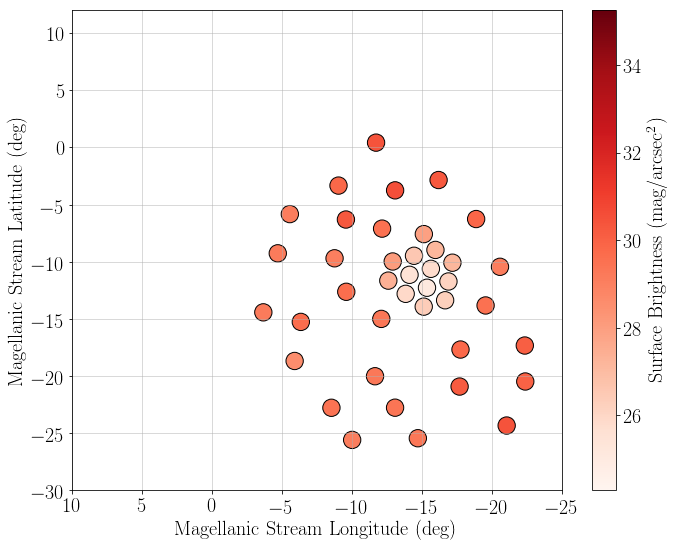

In [61]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
#ax.hist2d(ms_l, ms_b, bins = [900,500], cmin=1, norm = matplotlib.colors.LogNorm(), alpha = 0.7, cmap='viridis')
data_plot = ax.scatter(map_data.T[4], map_data.T[5], c = map_data.T[3], cmap = 'Reds', s = 300, edgecolors='black', vmin=24.3, vmax=35.25)
cbd = plt.colorbar(data_plot)
cbd.set_label('Surface Brightness (mag/arcsec$^2$)')
ax.grid(alpha = 0.6)
ax.set_ylim(-30,12)
ax.set_xlim(10,-25)
ax.set_xlabel('Magellanic Stream Longitude (deg)')
ax.set_ylabel('Magellanic Stream Latitude (deg)')
plt.tight_layout()
plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/old_map.png')
plt.show()
plt.close()

# Region plot

In [20]:
# Surface brightness calculator. It uses a corrected 2D histogram array where counts mean stars. The magnitudes are taken from the 3rd array inside the original data. Both arrays should have compatible sizes.
def plotting_different_regions(corrected_data, original_data, field_number, model, coordinates, data_set, field_area):
    #bin_number = int(175 + 0.15 * (len(data[0])/1000))
    #field_area_arcsec = 60 * 60 * 60 * 60 * field_area_calculator(coordinates, field_number, bin_number)
    field_area_arcsec = 60 * 60 * 60 * 60 * field_area
    
    #mags = original_data[2][:-1] + ybinsize/2
    #clrs = original_data[1][:-1] + xbinsize/2
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T

    young_vertex_coord = [(-1,14),(-1,20),(-0.2,23),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
    old_vertex_coord = [(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(0.75,23)]
    
    path = Path(young_vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))

    #cut_corrected_model = np.ma.masked_array(corrected_data, mask=grid.T)
    
    grid = ~np.array(grid)
    cut_corrected_data = np.ma.masked_array(corrected_data, mask=grid.T)



    # Set the overall figure for the CMD plotting
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':16})
    fig = plt.figure(figsize= (8,5))
    ax = fig.add_subplot(111)

    hist_final = ax.imshow(corrected_data.T, aspect = 'auto', origin = 'upper', extent = (min(original_data[1]), max(original_data[1]), max(original_data[2]), min(original_data[2])), cmap = 'Reds', norm = colors.SymLogNorm(0.1), interpolation = 'none')
    vertex_list = [list(x) for x in young_vertex_coord]
    vertex_array = np.array(vertex_list)
    polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.2, color = 'blue')
    ax.add_patch(polygon)
    vertex_list = [list(x) for x in old_vertex_coord]
    vertex_array = np.array(vertex_list)
    polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.2, color = 'green')
    ax.add_patch(polygon)
    plt.ylabel('$g$')
    plt.xlabel('$g-i$')
    cbd = plt.colorbar(hist_final)
    #plt.title('Field %s' % (field_number))
    #plt.show()
    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/CMD_young_vs_old_regions.png')
    plt.close()


    
    #Code for computing the SMC+MW SB.
    cut_corrected_data [cut_corrected_data < 0] = 0. #This line sets the bins to 0 if they are negative, to avoid having negative fluxes.
    stars_per_mag = np.nansum(cut_corrected_data, 0)
    #print(stars_per_mag)
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    total_flux = np.sum(flux_per_mag_and_star * stars_per_mag)
    flux_arcsec = total_flux / field_area_arcsec
#    print flux_arcsec
    mag_arcsec = -2.5*np.log10(flux_arcsec)
    
    
    #Code for computing the MW SB.
    #model_stars_per_mag = np.nansum(cut_corrected_model, 0)
    #model_flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    #model_total_flux = np.sum(model_flux_per_mag_and_star * model_stars_per_mag)
    
    return mag_arcsec, total_flux

In [88]:
model_name = 'mesa'
field_number = '3'
filterset = 'decam'

field_SB = []
field_error = []
model_field_flux = []
data_field_flux = []
print(model_name, filterset)
print('')
print(field_number)
name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field_number)
name_field_model = '/home/pol/PhD_DATA/MODELS/CMD_field%s_%s.txt' % (field_number, model_name)
field = 'Field %s' % (field_number)
data, header = read_fits(name_field_data)
model = read_txt(name_field_model)
coordinates = data['RA'], data['DEC']
bin_number = int(175 + 0.15 * (len(coordinates[0])/1000))
field_area = field_area_calculator(coordinates, field_number, bin_number)
corrected_data_hist, original_data = cmd_subtractor(data, model, field_number, model_name, filterset, field_area)

data_set = 'data'
temp1, temp2 = plotting_different_regions(corrected_data_hist, original_data, field_number, model_name, coordinates, data_set, field_area)
field_SB, data_field_flux = np.append(field_SB, temp1), np.append(data_field_flux, temp2)
            #print field_SB[-1], model_field_flux[-1], data_field_flux[-1]
            #Here we retrieve the SB of the model in the 2 different regions of the CMD, in and out of the area of study.
#model_flux_in, model_flux_out = model_SB(model)
            #print model_flux_in, model_flux_out
            
            #Now we calculate the part of the uncertainty due to the model.
#model_error = ((model_flux_in/data_field_flux[-1]) * (model_field_flux[-1]/model_flux_out))**2
          
            #Next the area error.
#area_error = 0.1 * 0.1
            
            #Finally the total error in the field.
#field_error.append( (2.5/np.log(10)) * np.sqrt(model_error + area_error) )
print 'The SB is:', field_SB[-1]

('mesa', 'decam')

3


/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


The SB is: 26.963704717386992


/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less


# Star count calculations

In [21]:
# Star count calculator. It uses a corrected 2D histogram array where counts mean stars. The magnitudes are taken from the 3rd array inside the original data. Both arrays should have compatible sizes.
def star_count_calculator(corrected_data, original_data, field_number, model, coordinates, data_set, field_area, population):
    #bin_number = int(175 + 0.15 * (len(data[0])/1000))
    #field_area_arcsec = 60 * 60 * 60 * 60 * field_area_calculator(coordinates, field_number, bin_number)
    field_area_arcsec = 60 * 60 * 60 * 60 * field_area
    
    #mags = original_data[2][:-1] + ybinsize/2
    #clrs = original_data[1][:-1] + xbinsize/2
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T

    if population == 'young': 
        vertex_coord = [(-1,14),(-1,20),(-0.2,23),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
    if population == 'old':
        vertex_coord = [(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(0.75,23)]
    if population == 'all':
        vertex_coord = [(-1,14),(-1,20),(0,24),(0.9,24),(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
    path = Path(vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))

    cut_corrected_model = np.ma.masked_array(corrected_data, mask=grid.T)
    
    grid = ~np.array(grid)
    cut_corrected_data = np.ma.masked_array(corrected_data, mask=grid.T)



    # Set the overall figure for the CMD plotting
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    #plt.rcParams.update({'font.size':20})
    #fig = plt.figure(figsize= (12,8))
    #ax = fig.add_subplot(111)

    #hist_final = ax.imshow(corrected_data.T, aspect = 'auto', origin = 'upper', extent = (min(original_data[1]), max(original_data[1]), max(original_data[2]), min(original_data[2])), cmap = 'viridis_r', norm = colors.SymLogNorm(0.1), interpolation = 'none')
    #vertex_list = [list(x) for x in vertex_coord]
    #vertex_array = np.array(vertex_list)
    #polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, color = 'orange')
    #ax.add_patch(polygon)
    #vertex_list = [list(x) for x in halo_vertex_coord]
    #vertex_array = np.array(vertex_list)
    #polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.4, color = 'red')
    #ax.add_patch(polygon)
    #plt.ylabel('$g$')
    #plt.xlabel('$g-i$')
    #cbd = plt.colorbar(hist_final)
    #plt.title('Field %s' % (field_number))

    #plt.tight_layout()
    #plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/CMD_modelzone_field%s_%s_%s.png' % (field_number, model, data_set))
    #plt.close()


    
    #Code for computing the SMC+MW SB.
    cut_corrected_data [cut_corrected_data < 0] = 0. #This line sets the bins to 0 if they are negative, to avoid having negative fluxes.
    stars_per_mag = np.nansum(cut_corrected_data, 0)
    #print(stars_per_mag)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    total_flux = np.sum(flux_per_mag_and_star * stars_per_mag)
    total_stars = np.sum(stars_per_mag)
    flux_arcsec = total_flux / field_area_arcsec
#    print flux_arcsec
    mag_arcsec = -2.5*np.log10(flux_arcsec)
    
    
    
    
    #Code for computing the MW SB.
    model_stars_per_mag = np.nansum(cut_corrected_model, 0)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    model_flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    model_total_flux = np.sum(model_flux_per_mag_and_star * model_stars_per_mag)
    total_model_stars = np.sum(model_stars_per_mag)
    
    return total_stars, total_model_stars

In [22]:
# Function to retrieve the surface brightness of the model for each field.
def model_star_counts_function(model, population):
        
    model_g = model[1]
    model_gi = model[1] - model[3]
    
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T
    
    if population == 'young': 
        vertex_coord = [(-1,14),(-1,20),(-0.2,23),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
    else:
        vertex_coord = [(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(0.75,23)]
    path = Path(vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))
    
    model_2dhist, xedges, yedges = np.histogram2d(model_gi, model_g, bins = [xbins,ybins])
    
    cut_model_out = np.ma.masked_array(model_2dhist, mask=grid.T)
    grid = ~np.array(grid)
    cut_model_in = np.ma.masked_array(model_2dhist, mask=grid.T)
    
    stars_per_mag = np.nansum(cut_model_in, 0)
    model_stars_in = np.sum(stars_per_mag)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    #flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    #flux_in = np.sum(flux_per_mag_and_star * stars_per_mag)
    
    stars_per_mag = np.nansum(cut_model_out, 0)
    model_stars_out = np.sum(stars_per_mag)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    #flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    #flux_out = np.sum(flux_per_mag_and_star * stars_per_mag)
    
    return model_stars_in, model_stars_out

In [23]:
# Function that constructs the SC profile based on the retrieved magnitudes and the radial distance from the center of the SMC.
def StarCounts_profile(fields_data, fields_errors, fields_coord, population):

    distance_SMC = 62#kpc
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':22})
    fig = plt.figure(figsize= (12,9))
    ax = fig.add_subplot(111)
    
    # first draw a circle in the cylindrical JCh color space. 
    # the third channel is hue in degrees. First is lightness and the second chroma
    color_circle = np.ones((256,3))*60
    color_circle[:,1] = np.ones((256))*45
    color_circle[:,2] = np.arange(0,360,360.0/256.0)
    color_circle_rgb = cspace_convert(color_circle, "JCh","sRGB1")
    cm2 = colors.ListedColormap(color_circle_rgb)

    fields_coord = fields_coord.T
    plot = ax.scatter(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC, fields_data, c = fields_coord[2], cmap=cm2, vmin = 0, vmax = 360, s = 80, zorder=10)
    plt.errorbar(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC, fields_data, yerr = fields_errors, fmt='none', zorder=1)
    #for i, field_number in enumerate(fields_coord[0]):
    #    plt.annotate(field_number, (str(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC), str(fields_data)))
    cb = plt.colorbar(plot)
    cb.set_label('Position Angle ($^\circ$)')
    plt.xlim(xmin=0)
    #plt.ylim(ymin=23, ymax=32)
    plt.yscale('log')
    plt.xlabel('r (kpc)')
    plt.ylabel('Star Counts')
    #plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/StarCounts_profile_15deg_errors_%s_13D.pdf' % (population))
    plt.close()

In [30]:
population = 'old'
sc_data = np.loadtxt('/home/pol/Documents/PhD/CMD_SMASH/StarCounts_errors_%s_15deg_13D.dat' % (population))

StarCounts_profile(sc_data.T[3], sc_data.T[4], field_coord_SMC, population)

In [199]:
population_list = ['young', 'old', 'all']

for filterset in coeff_list:
    for model_name in model_list:
        for population in population_list:
            field_star_counts = []
            field_error = []
            model_star_counts = []
            data_field_flux = []
            print model_name, filterset 
            print ''
            for field_number, field_area in zip(field_list, areas):
                if field_number == '4' or field_number == '9' or field_number == '1':
                    name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits' % (field_number)
                else:
                    name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field_number)
                name_field_model = '/home/pol/PhD_DATA/MODELS/CMD_field%s_%s.txt' % (field_number, model_name)
                field = 'Field %s' % (field_number)
                data, header = read_fits(name_field_data)
                model = read_txt(name_field_model)
                coordinates = data['RA'], data['DEC']
                corrected_data_hist, original_data = cmd_subtractor(data, model, field_number, model_name, filterset, field_area, population, halo_scaling = False)



                data_set = 'data'
                temp1, temp2 = star_count_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, data_set, field_area, population)

                #We need to scale the count number for the area of the field.
                temp1 = temp1 / field_area
                field_star_counts, model_star_counts = np.append(field_star_counts, temp1), np.append(model_star_counts, temp2)

                #Here we retrieve the SB of the model in the 2 different regions of the CMD, in and out of the area of study.
                #model_star_counts_in, model_star_counts_out = model_star_counts_function(model, population)
                #print model_flux_in, model_flux_out

                #Now we calculate the part of the uncertainty due to the model.
                if population == 'young':
                    model_error = 20 * 20
                if population == 'old':
                    model_error = 700 * 700
                if population == 'all':
                    model_error = 1500 * 1500

                #Next the area error.
                area_error = (field_star_counts[-1]*0.1)**2

                #Finally the total error in the field.
                field_error.append( np.sqrt(model_error + area_error ) / field_area )
                
                print field_number, population
                print 'The star count is:', field_star_counts[-1], '+/-', field_error[-1]

                #field_SB.append(surface_brightness_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, num_stars))
                print ''
            StarCounts_profile(field_star_counts, field_error, field_coord_SMC, population)
            SC_data = np.stack((field_coord_SMC[:,0], field_coord_SMC[:,1], field_coord_SMC[:,2], field_star_counts, field_error)).T
            np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/StarCounts_errors_%s_15deg_13D.dat' % (population), SC_data, header='Field_number Distance_SMC(deg) PA(deg) SC(deg^(-2)) SC_error(deg^(-2))', fmt= '%.0f %.3f %.3f %.5f %.5f')
            #np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/SB_data_errors_%s_%s_15deg_29S_TeXtable.dat' % (model_name, filterset), SB_data, fmt= '%.0f & %.3f & %.3f & %.5f $\pm$ %.5f \\')
        


mesa decam

hola


/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less


1 young
The star count is: 283.5341365461847 +/- 13.93473640723201

hola
2 young
The star count is: 202.98507462686567 +/- 10.632884198960186

hola
3 young
The star count is: 30216.666666666668 +/- 1094.8307444128186

hola
4 young
The star count is: 7989.719626168224 +/- 746.9366776548353

hola
5 young
The star count is: 32928.865501553526 +/- 1197.4353769381507

hola
6 young
The star count is: 201956.2962962963 +/- 7479.866493614775

hola
7 young
The star count is: 28118.77371015642 +/- 1018.8219191931884

hola
8 young
The star count is: 22.09737827715356 +/- 7.53621844184156

hola
9 young
The star count is: 9095.901639344262 +/- 745.7459152551651

hola
10 young
The star count is: 235740.6701146025 +/- 8963.52680431847

hola
11 young
The star count is: 96681.95379690759 +/- 3502.976835526232

hola
12 young
The star count is: 6312.4555160142345 +/- 224.7552690550776

hola
13 young
The star count is: 137.96051692265763 +/- 8.771382326785545

hola
14 young
The star count is: 18207.049136

/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


hola
16 young
The star count is: 8711.785714285716 +/- 311.2171840163755

hola
17 young
The star count is: 22.158647417778848 +/- 7.536470790460191

hola
18 young
The star count is: 1978.4386617100372 +/- 73.92274900068782

hola
19 young
The star count is: 135.3658536585366 +/- 9.817213244191178

hola
20 young
The star count is: 20.233908729048164 +/- 8.30664966744042

hola
21 young
The star count is: 21.039660371796163 +/- 8.109017068966667

hola
22 young
The star count is: 99.7018658011355 +/- 8.497096090429812

hola
23 young
The star count is: 12.601626016260163 +/- 8.146203625955016

hola
24 young
The star count is: 29.906542056074766 +/- 9.44970288263937

hola
25 young
The star count is: 36.885245901639344 +/- 8.334953397650027

hola
139 young
The star count is: 20.22566787779517 +/- 7.614397448118223

hola
141 young
The star count is: 14.360977156539631 +/- 7.988642680345713

hola
142 young
The star count is: 16.356877323420075 +/- 7.459767801167967

hola
143 young
The star count

# Calculation of error in both zones

In [49]:
# We want to have a file with the basic data of each field summarized. So far, this data includes:
#   - Field number
#   - Degrees from SMC centre
#   - Position Angle
#   - Area in deg^2
coord_list = read_txt('/home/pol/PhD_DATA/SMASH_DATA/smash_fields_final.txt', cols = (0,4,5))
field_coord_SMC = np.array(coordinate_calculator(coord_list))

inner_radius = np.where(field_coord_SMC[:,1] > 9)
inner_fields = field_coord_SMC[inner_radius,0]
field_list = [str(int(x)) for x in inner_fields[0]]

field_coord_SMC = np.array(coordinate_calculator(coord_list))
field_coord_SMC.shape = len(field_list), 3
print field_coord_SMC.shape

(27, 3)


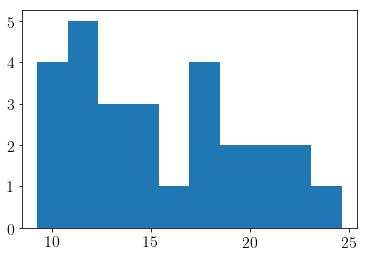

[[  8.           9.6462529  180.42172114]
 [ 17.          11.88537873 172.08445314]
 [ 23.          12.58383539  84.51824155]
 [ 24.          10.44406197 105.23698616]
 [ 25.          10.87891728 145.62851256]
 [ 33.          15.24257665 160.69853133]
 [ 62.          17.74764711 173.42985285]
 [130.          19.30662227 183.4626771 ]
 [131.          22.63146029 191.14500232]
 [133.          24.62633907 202.43854581]
 [134.          18.44138539 194.16287509]
 [135.          20.69627988 207.07459551]
 [136.          18.32403733 217.04380573]
 [137.          19.08588877 228.08800997]
 [138.          15.49980562 203.69537511]
 [139.          14.9625936  227.34180546]
 [140.          17.56863764 255.09682866]
 [141.          13.04232111 217.13298104]
 [142.          13.90789315 243.8732731 ]
 [143.          11.44759371 235.53138019]
 [144.          13.81697875 268.51889784]
 [145.           9.59179746 259.21425811]
 [147.          11.09453134 282.53589907]
 [148.          11.6833123  195.57

In [50]:
plt.hist(field_coord_SMC.T[1])
plt.show()
plt.close()
print field_coord_SMC

In [134]:
# Star count calculator. It uses a corrected 2D histogram array where counts mean stars. The magnitudes are taken from the 3rd array inside the original data. Both arrays should have compatible sizes.
def star_count_calculator_for_error(corrected_data, original_data, field_number, model, coordinates, data_set, field_area, population):
    #bin_number = int(175 + 0.15 * (len(data[0])/1000))
    #field_area_arcsec = 60 * 60 * 60 * 60 * field_area_calculator(coordinates, field_number, bin_number)
    field_area_arcsec = 60 * 60 * 60 * 60 * field_area
    
    #mags = original_data[2][:-1] + ybinsize/2
    #clrs = original_data[1][:-1] + xbinsize/2
    mags = ybins[:-1] + ybinsize/2
    clrs = xbins[:-1] + xbinsize/2
    
    x, y = np.meshgrid(clrs,mags)
    x, y = x.flatten(), y.flatten()
    cells = np.vstack((x,y)).T

    if population == 'young': 
        vertex_coord = [(-1,14),(-1,20),(-0.2,23),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
    if population == 'old':
        vertex_coord = [(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(0.75,23)]
    if population == 'all':
        vertex_coord = [(-1,14),(-1,20),(0,24),(0.9,24),(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)]
    path = Path(vertex_coord)
    grid = path.contains_points(cells)
    grid = grid.reshape((np.ma.size(mags),np.ma.size(clrs)))

    cut_corrected_model = np.ma.masked_array(corrected_data, mask=grid.T)
    
    grid = ~np.array(grid)
    cut_corrected_data = np.ma.masked_array(corrected_data, mask=grid.T)



    # Set the overall figure for the CMD plotting
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    #plt.rcParams.update({'font.size':20})
    #fig = plt.figure(figsize= (12,8))
    #ax = fig.add_subplot(111)

    #hist_final = ax.imshow(corrected_data.T, aspect = 'auto', origin = 'upper', extent = (min(original_data[1]), max(original_data[1]), max(original_data[2]), min(original_data[2])), cmap = 'viridis_r', norm = colors.SymLogNorm(0.1), interpolation = 'none')
    #vertex_list = [list(x) for x in vertex_coord]
    #vertex_array = np.array(vertex_list)
    #polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, color = 'orange')
    #ax.add_patch(polygon)
    #vertex_list = [list(x) for x in halo_vertex_coord]
    #vertex_array = np.array(vertex_list)
    #polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.4, color = 'red')
    #ax.add_patch(polygon)
    #plt.ylabel('$g$')
    #plt.xlabel('$g-i$')
    #cbd = plt.colorbar(hist_final)
    #plt.title('Field %s' % (field_number))

    #plt.tight_layout()
    #plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/CMD_modelzone_field%s_%s_%s.png' % (field_number, model, data_set))
    #plt.close()


    
    #Code for computing the SMC+MW SB.
    #cut_corrected_data [cut_corrected_data < 0] = 0. #This line sets the bins to 0 if they are negative, to avoid having negative fluxes.
    stars_per_mag = np.nansum(cut_corrected_data, 0)
    #print(stars_per_mag)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    total_flux = np.sum(flux_per_mag_and_star * stars_per_mag)
    total_stars = np.sum(stars_per_mag)
    #flux_arcsec = total_flux / field_area_arcsec
#    print flux_arcsec
    #mag_arcsec = -2.5*np.log10(flux_arcsec)
    
    
    
    
    #Code for computing the MW SB.
    model_stars_per_mag = np.nansum(cut_corrected_model, 0)
#    flux_per_mag_and_star = np.power(2.511864, -mags) #David's way
    model_flux_per_mag_and_star = np.power(10, -mags/2.5) #My way
    model_total_flux = np.sum(model_flux_per_mag_and_star * model_stars_per_mag)
    total_model_stars = np.sum(model_stars_per_mag)
    
    return total_stars, total_model_stars

In [169]:
population_list = ['all']

for filterset in coeff_list:
    for model_name in model_list:
        for population in population_list:
            field_star_counts = []
            field_error = []
            model_star_counts = []
            data_field_flux = []
            print model_name, filterset 
            print ''
            for field_number, field_area in zip(field_list, areas):
                if field_number == '4' or field_number == '9' or field_number == '1':
                    name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits' % (field_number)
                else:
                    name_field_data = '/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field_number)
                name_field_model = '/home/pol/PhD_DATA/MODELS/CMD_field%s_%s.txt' % (field_number, model_name)
                field = 'Field %s' % (field_number)
                data, header = read_fits(name_field_data)
                model = read_txt(name_field_model)
                coordinates = data['RA'], data['DEC']
                corrected_data_hist, original_data = cmd_subtractor(data, model, field_number, model_name, filterset, field_area, halo_scaling = False)



                data_set = 'data'
                temp1, temp2 = star_count_calculator_for_error(corrected_data_hist, original_data, field_number, model_name, coordinates, data_set, field_area, population)

                #We need to scale the count number for the area of the field.
                #We will consider a whole field to have 3 deg^2 and scale to this.
                temp1 = temp1 #/ field_area

                field_star_counts, model_star_counts = np.append(field_star_counts, temp1), np.append(model_star_counts, temp2)

                #Here we retrieve the SB of the model in the 2 different regions of the CMD, in and out of the area of study.
                #model_star_counts_in, model_star_counts_out = model_star_counts_function(model, population)
                #print model_flux_in, model_flux_out

                #Now we calculate the part of the uncertainty due to the model.
                #model_error = ((model_flux_in/data_field_flux[-1]) * (model_field_flux[-1]/model_flux_out))**2

                #Next the area error.
                area_error = (field_star_counts[-1]*0.1) / field_area**2

                #Finally the total error in the field.
                # POISSONIAN ERROR
                #field_error.append( np.sqrt(field_star_counts[-1]) )
                field_error.append( np.sqrt(field_star_counts[-1] + area_error**2 ) )
                print field_number
                print 'The star count is:', field_star_counts[-1], '+/-', field_error[-1]

                #field_SB.append(surface_brightness_calculator(corrected_data_hist, original_data, field_number, model_name, coordinates, num_stars))
                print ''
            #StarCounts_profile(field_star_counts, field_error, field_coord_SMC, population)
            #SB_data = np.stack((field_coord_SMC[:,0], field_coord_SMC[:,1], field_coord_SMC[:,2], field_star_counts, field_error)).T
            #np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/StarCounts_data_errors_%s_15deg_6D.dat' % (population), SB_data, header='Field_number Distance_SMC(deg) PA(deg) SC(deg^(-2)) SB_error(mag/arcsec^2)', fmt= '%.0f %.3f %.3f %.5f %.5f')
            #np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/SB_data_errors_%s_%s_15deg_29S_TeXtable.dat' % (model_name, filterset), SB_data, fmt= '%.0f & %.3f & %.3f & %.5f $\pm$ %.5f \\')


mesa decam

8
The star count is: 7361.391839537283 +/- 134.1327445836943

17
The star count is: 7706.636354968337 +/- 139.00498546438334

23
The star count is: 3626.1460580659514 +/- 84.84927035051055

24
The star count is: 4486.114647172137 +/- 118.58954452315287

25
The star count is: 9293.205748082977 +/- 183.03963634224522

33
The star count is: 7958.12965859848 +/- 158.5404193773038

62
The star count is: 4583.755485668222 +/- 92.5294686463785

130
The star count is: 5176.645433852083 +/- 99.02555764418966

131
The star count is: 8322.448925642027 +/- 143.02008270546395

133
The star count is: 7670.133454045717 +/- 131.34905795431047

134
The star count is: 6841.933513721993 +/- 132.12938451446428

135
The star count is: 7178.563595199264 +/- 133.6652846027031

136
The star count is: 4868.099813802942 +/- 110.55903502159106

137
The star count is: 3142.416235995637 +/- 73.30222599572716

138
The star count is: 5393.1442322139565 +/- 115.75932770087576

139
The star count is: 3942.

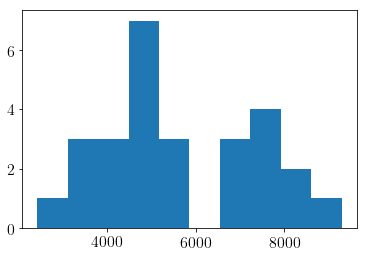

5637.288396888155 1747.0647296293857


In [170]:
plt.hist(field_star_counts)
plt.show()
print np.mean(field_star_counts), np.std(field_star_counts)

In [154]:
# We want to get the list of GALACTIC coordinates.
def galactic_coordinate_calculator (coordinates_data):
    field_list_2 = np.array([int(x) for x in field_list])
    coordinates_data = coordinates_data.T
    coordinates = []
    for field in coordinates_data:
        for selected in field_list_2:
            if field[0] == selected:
                field_data = []
                field_data.append(selected)
                field_coord =  SkyCoord(ra = field[1]*u.degree, dec = field[2]*u.degree)
                #print field_coord.galactic.l.deg
                field_data.append(field_coord.galactic.l.deg)
                field_data.append(field_coord.galactic.b.deg)
                coordinates.append(field_data)
    return coordinates

In [155]:
galactic_coordinates = np.array(galactic_coordinate_calculator(coord_list))
print galactic_coordinates

[[  8.         302.96626591 -34.65419489]
 [ 17.         300.96865385 -32.50012477]
 [ 23.         285.2206269  -44.06207455]
 [ 24.         289.48988324 -40.68222886]
 [ 25.         295.40020134 -35.01799502]
 [ 33.         297.1710734  -29.72402809]
 [ 62.         300.69878609 -26.63284084]
 [130.         304.20782169 -25.02699335]
 [131.         307.56442182 -22.01222239]
 [133.         312.78281709 -21.10275503]
 [134.         307.89045361 -26.32240865]
 [135.         313.19801022 -25.39998301]
 [136.         315.41906987 -28.97035668]
 [137.         319.27827027 -30.32615604]
 [138.         310.02872244 -29.89545539]
 [139.         316.03075064 -33.39953318]
 [140.         324.4782171  -37.71554816]
 [141.         312.29150433 -33.52624006]
 [142.         318.55257272 -37.10440551]
 [143.         314.71449241 -37.22524777]
 [144.         321.68044692 -42.45288895]
 [145.         315.50866717 -41.84772509]
 [147.         318.38667057 -45.74114757]
 [148.         306.60853751 -32.99

In [171]:
b_fit, b_fit_cov = np.polyfit(galactic_coordinates.T[2], np.log(field_star_counts), 1, cov = True)
fit_fn = np.poly1d(b_fit)
print b_fit, b_fit_cov

[0.02436372 9.3819001 ] [[7.28254421e-05 2.37647106e-03]
 [2.37647106e-03 8.09015969e-02]]


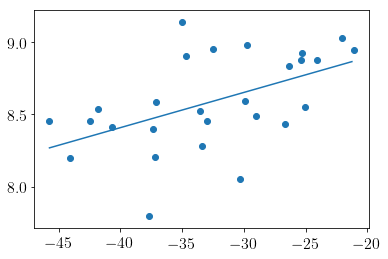

In [172]:
b_values = np.arange(min(galactic_coordinates.T[2]), max(galactic_coordinates.T[2]), 0.5)
plt.scatter(galactic_coordinates.T[2], np.log(field_star_counts))
plt.plot(b_values, fit_fn(b_values))
#plt.yscale('log')
plt.show()

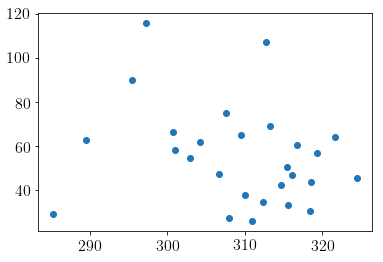

In [139]:
plt.scatter(galactic_coordinates.T[1], field_star_counts)
plt.show()

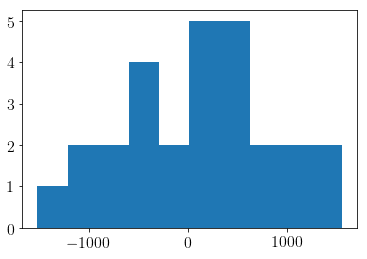

In [166]:
new_field_star_count = field_star_counts - np.exp(fit_fn(galactic_coordinates.T[2]))
plt.hist(new_field_star_count)
plt.show()

In [168]:
print np.mean(new_field_star_count), np.std(new_field_star_count)

97.39034489807662 739.7287860566807


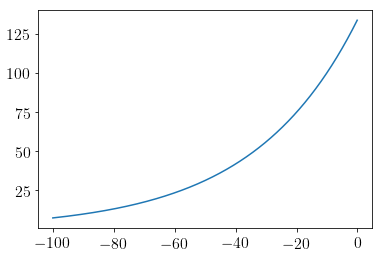

In [145]:
x_values = np.arange(-100,0,0.1)
plt.plot(x_values, np.exp(fit_fn(x_values)))
plt.show()